In [38]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag, map_tag
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [2]:
pf_df = pd.read_csv('kaggle_poem_dataset.csv')
pf_df['Author'] = pf_df.Author.astype('category')
pf_df.columns = [name.lower() for name in pf_df.columns]
pf_df.info()
pf_df = pf_df.drop(['unnamed: 0', 'poetry foundation id'], axis=1)
pf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15652 entries, 0 to 15651
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   unnamed: 0            15652 non-null  int64   
 1   author                15652 non-null  category
 2   title                 15652 non-null  object  
 3   poetry foundation id  15652 non-null  int64   
 4   content               15652 non-null  object  
dtypes: category(1), int64(2), object(2)
memory usage: 674.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15652 entries, 0 to 15651
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   author   15652 non-null  category
 1   title    15652 non-null  object  
 2   content  15652 non-null  object  
dtypes: category(1), object(2)
memory usage: 430.2+ KB


In [3]:
# create function to clean lines
import string, re
from nltk.corpus import words
import multiprocessing as mp
def clean_text(text):
    text = text.lower()
    text = text.replace('\%','')
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    text = " ".join(filter(lambda x:x[0]!="@", text.split()))
    return text

def clean_list(list_of_strings):
    return [clean_text(string) for string in list_of_strings]

In [4]:
# create column to store document as list of lines
pf_df['line'] = pf_df.content.str.split('\n')
pf_df['line'] = pf_df.line.map(clean_list)
print(pf_df.iloc[0])

author                                        Wendy Videlock
title                                                      !
content    Dear Writers, I’m compiling the first in what ...
line       [dear writers i’m compiling the first in what ...
Name: 0, dtype: object


In [5]:
# construct function to remove empty lines for accurate line count
def remove_empty_lines(list_of_lines):
    try:
        return [i for i in list_of_lines if i]
    except TypeError:
        return pd.NA
    
pf_df['line'] = pf_df.line.map(remove_empty_lines)
print(pf_df.iloc[0])

author                                        Wendy Videlock
title                                                      !
content    Dear Writers, I’m compiling the first in what ...
line       [dear writers i’m compiling the first in what ...
Name: 0, dtype: object


In [6]:
# create column for length of poem in lines
pf_df['length_in_lines'] = pf_df.line.map(len)
pf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15652 entries, 0 to 15651
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   author           15652 non-null  category
 1   title            15652 non-null  object  
 2   content          15652 non-null  object  
 3   line             15652 non-null  object  
 4   length_in_lines  15652 non-null  int64   
dtypes: category(1), int64(1), object(3)
memory usage: 674.7+ KB


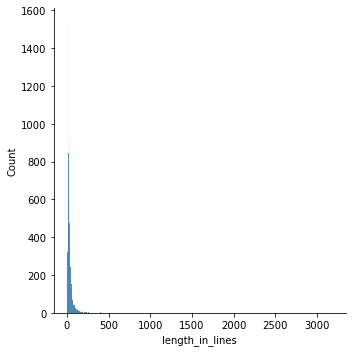

In [7]:
sns.displot(pf_df.length_in_lines)

In [8]:
# filtering outliers with zscore
from scipy import stats
clean_df = pf_df[(np.abs(stats.zscore(pf_df.length_in_lines)) < 2.5)]

In [9]:
# filter sub-haiku length works
clean_df = clean_df[clean_df.length_in_lines > 2]

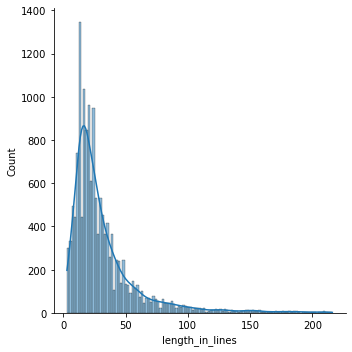

In [10]:
sns.displot(clean_df.length_in_lines, kde=True)

In [11]:
def lexical_diversity(line_list):
    doc_string = ' '.join(line_list)
    words = word_tokenize(doc_string)
    return (len(set(words))/len(words))
        
clean_df['lexical_diversity'] = clean_df.line.map(lexical_diversity)

In [39]:
clean_df.head()
with open('clean_df.pkl', 'wb') as f:
    pickle.dump(clean_df, f)

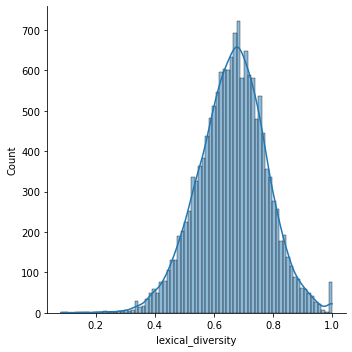

In [13]:
sns.displot(clean_df.lexical_diversity, kde=True)

In [14]:
# sample 3 lines from each poem
# import random
# clean_df.line.describe()
# docs_in_lines = clean_df.line.to_list()
# line_samples = [random.sample(lines,3) for lines in docs_in_lines]

In [15]:
line_df = clean_df.explode('line').drop(['length_in_lines', 'content','lexical_diversity'],axis=1)

In [16]:
line_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488333 entries, 1 to 15651
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   author  488333 non-null  category
 1   title   488333 non-null  object  
 2   line    488333 non-null  object  
dtypes: category(1), object(2)
memory usage: 12.3+ MB


In [18]:
line_df['words'] = line_df.line.map(word_tokenize)
line_df.head()

,author,title,line,words
1,Hailey Leithauser,0,philosophic,[philosophic]
1,Hailey Leithauser,0,in its complex ovoid emptiness,"[in, its, complex, ovoid, emptiness]"
1,Hailey Leithauser,0,a skillful pundit coined it as a sort,"[a, skillful, pundit, coined, it, as, a, sort]"
1,Hailey Leithauser,0,of stopgap doorstop for those,"[of, stopgap, doorstop, for, those]"
1,Hailey Leithauser,0,quaint equations,"[quaint, equations]"


In [19]:
line_df['length_in_words'] = line_df.words.map(len)

In [20]:
line_df.describe()

,length_in_words
count,488333.000000
mean,7.025565
std,5.874501
min,1.000000
25%,5.000000
50%,7.000000
75%,9.000000
max,636.000000


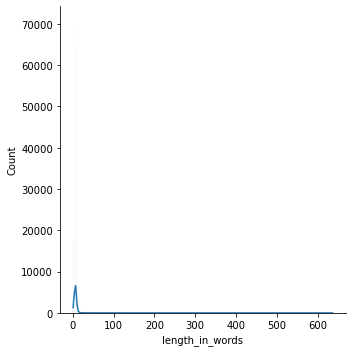

In [21]:
x = line_df.length_in_words
sns.displot(x, kde=True)

In [22]:
# filtering outliers with zscore
from scipy import stats
clean_line_df = line_df[(np.abs(stats.zscore(line_df.length_in_words)) < 2.5)]

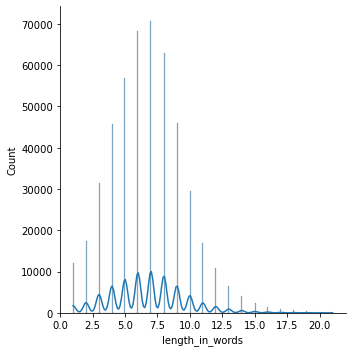

In [23]:
# fig, ax = plt.subplots()
x = clean_line_df.length_in_words
sns.displot(x, kde=True)
# plt.tight_layout()

In [24]:
line_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488333 entries, 1 to 15651
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   author           488333 non-null  category
 1   title            488333 non-null  object  
 2   line             488333 non-null  object  
 3   words            488333 non-null  object  
 4   length_in_words  488333 non-null  int64   
dtypes: category(1), int64(1), object(3)
memory usage: 19.7+ MB


In [25]:
clean_line_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485604 entries, 1 to 15651
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   author           485604 non-null  category
 1   title            485604 non-null  object  
 2   line             485604 non-null  object  
 3   words            485604 non-null  object  
 4   length_in_words  485604 non-null  int64   
dtypes: category(1), int64(1), object(3)
memory usage: 19.6+ MB


In [26]:
clean_line_df['lexical_diversity'] = clean_line_df.words.map(lexical_diversity)

<ipython-input-26-5b05ab53e382>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_line_df['lexical_diversity'] = clean_line_df.words.map(lexical_diversity)


In [40]:
clean_line_df.head()
with open('clean_line_df.pkl', 'wb') as f:
    pickle.dump(clean_line_df, f)

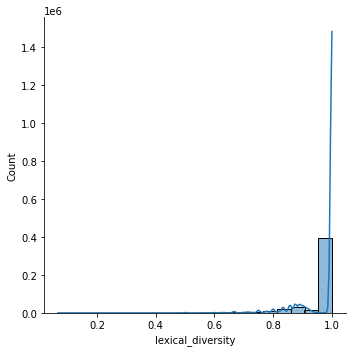

In [28]:
sns.displot(clean_line_df.lexical_diversity, kde=True)

In [29]:
author_line_lexical = clean_line_df.drop(['title','line','words'], axis=1).groupby('author').mean()

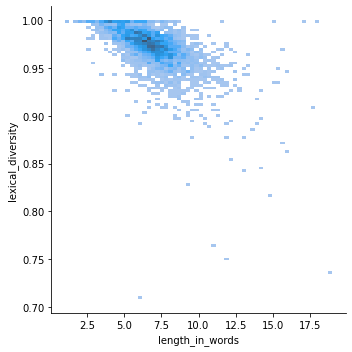

In [30]:
author_line_lexical.reset_index(inplace=True)
sns.displot(data=author_line_lexical, x='length_in_words',y='lexical_diversity')

In [31]:
author_line_lexical.describe()

,length_in_words,lexical_diversity
count,3249.000000,3249.000000
mean,6.880859,0.972169
std,1.864858,0.020988
min,1.000000,0.708333
25%,5.741294,0.963586
50%,6.795872,0.975167
75%,7.901408,0.985061
max,19.000000,1.000000


In [32]:
# author_line_lexical_mode = clean_line_df.drop(['title','line','words'], axis=1).groupby('author').mode()
# author_line_lexical_mode.reset_index(inplace=True)
# sns.displot(data=author_line_lexical_avg, x='length_in_words',y='lexical_diversity')